In [1]:
import numpy as np
from matplotlib.image import imread, imsave
from skimage import color
import matplotlib.pyplot as plt
from scipy import signal

Canny algorithm: <br>
1. Gaussian filter (convolution with gaussian kernel)<br>
2. Finding intensity gradient (convolution with sobel kernel)<br>
3. Non maximum suppression<br>
4. Edge tracking

In [2]:
def smooth_img(img):
    """convolves img with a 3x3 gaussian filter
    
    params:
        img = image to which the smoothing is applied
        
    returns:
        blurred_img = smoothed image
    
    """
    g1 = np.array([[1, 2, 1]])
    gaussian = g1.T @ g1
    gaussian = gaussian / np.sum(gaussian)
    blurred_img = signal.convolve2d(img, gaussian, mode='same')
    return blurred_img

In [3]:
def get_gradient(img):
    """get_gradient computes the gradient and returns 2 matrices
    
    params:
        img = image for which the gradient is to be computed
    
    returns:
        mags = magnitude of gradients
        theta = direction of gradients
    """
    mags = np.zeros(img.shape)
    theta = np.zeros(img.shape)
    
    #construct sobel kernel
    s1 = np.array([[1, 2, 1]])
    s2 = np.array([[-1, 0, 1]])
    sobel_x = s1.T @ s2
    sobel_y = sobel_x.T
    
    mag_x = signal.convolve2d(img, sobel_x, mode='valid')
    mag_y = signal.convolve2d(img, sobel_y, mode='valid')
    
    mags = abs(mag_x) + abs(mag_y)
    theta = np.arctan2(mag_y, mag_x) * 180 / np.pi
    return mags, theta

In [4]:
#Non maximum suppression
def non_max_suppression(mag, theta):
    """Takes the angle and the magnitued of the gradient and 
    suppresses edges which are in close proximity to another
    
    params:
        mag = magnitued of gradient
        theta = direction of gradient
        
    returns:
        output = image with only locally dominant edges
    
    """
    output = np.zeros(mag.shape)
    for x in range(mag.shape[0] - 1):
        for y in range(mag.shape[1] - 1):
            # vertical lines, 0 / 180 deg
            if (theta[x, y] > -22.5 and theta[x, y] < 22.5 or 
                theta[x, y] < -157.5 or theta[x, y] > 157.5):
                if mag[x, y] >= mag[x, y + 1] and mag[x, y] >= mag[x, y - 1]:
                    output[x, y] = mag[x, y]
                    
            # diag 1, 45 / - 135 deg
            if (theta[x, y] > 22.5 and theta[x, y] < 67.5 or 
                theta[x, y] < -112.5 and theta[x, y] > -157.5):
                if mag[x, y] >= mag[x - 1, y - 1] and mag[x, y] >= mag[x + 1, y + 1]:
                    output[x, y] = mag[x, y]
                    pass
            
            # diag 2, 135 / - 45 deg
            if (theta[x, y] > 112.5 and theta[x, y] < 157.5 or 
                theta[x, y] < -22.5 and theta[x, y] > -67.5):
                if mag[x, y] >= mag[x + 1, y - 1] and mag[x, y] >= mag[x - 1, y + 1]:
                    output[x, y] = mag[x, y]
                    pass
                    
            # horizontal lines, 90, -90 deg
            if (theta[x, y] > 67.5 and theta[x, y] < 112.5 or
                theta[x, y] < -67.5 and theta[x, y] > -112.5):
                if mag[x, y] >= mag[x + 1, y] and mag[x, y] >= mag[x - 1, y]:
                    output[x, y] = mag[x, y]

    return output

In [5]:
#Double threshold / edge tracking
def edge_tracking(img):
    """uses edge intensity as a 'probability' for being an edge,
    very low values are deleted very strong edges are set to 1
    and weak / intermediate edges are only kept if they extend
    from a strong edge
    
    params:
        img = image with edges of various strengths
        
    returns:
        output = image with 'clean' edges
    
    """
    
    output = np.zeros(img.shape)    
    lower_th = np.percentile(img[img > 0], 20)
    upper_th = np.percentile(img[img > 0], 80)
    output[img > lower_th] = 0.5
    output[img > upper_th] = 1
    strong = []
    for x in range(1, img.shape[0] - 1):
        for y in range(1, img.shape[1] - 1):
            if output[x, y] == 1:
                strong.append((x, y))

    while len(strong):
        coord = strong.pop()
        x, y = coord[0], coord[1]
        output[x, y] = 1
        for dx in range(-1, 2):
            x_n = x + dx
            if 0 <= x_n < img.shape[0]:
                for dy in range(-1, 2):                
                    y_n = y + dy
                    if 0 <= y_n < img.shape[1]:
                        if x != x_n or y != y_n:
                            if output[x_n, y_n] == 0.5:
                                strong.append((x_n, y_n))
                                output[x_n, y_n] = 1
    output[output < 1] = 0
    return output

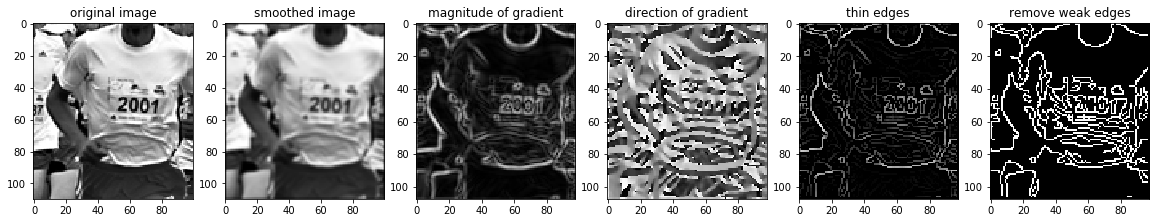

In [6]:
#Read image
img = imread('testimg.png')
img = color.rgb2gray(img)

plt.figure(figsize=(20,10))
plt.subplot(161)
plt.title('original image')
plt.imshow(img, cmap=plt.cm.gray)

#Gaussian filter
plt.subplot(162)
plt.title('smoothed image')
blurred_img = smooth_img(img)
plt.imshow(blurred_img, cmap=plt.cm.gray)

#Finding intensity gradient
mag, theta = get_gradient(blurred_img)
plt.subplot(163)
plt.title('magnitude of gradient')
plt.imshow(mag, cmap=plt.cm.gray)
plt.subplot(164)
plt.title('direction of gradient')
plt.imshow(theta, cmap=plt.cm.gray)

#suppress non maximum edges in gradient direction
canny = non_max_suppression(mag, theta)
plt.subplot(165)
plt.title('thin edges')
plt.imshow(canny, cmap=plt.cm.gray)

#extend strong edges and remove unconnected weak edges
tracked = edge_tracking(canny)
plt.subplot(166)
plt.title('remove weak edges')
plt.imshow(tracked, cmap=plt.cm.gray)
plt.show()